# **Face Super-Resolution Through Wasserstein GANs (2017)**


```
Chen, Zhimin, and Yuguang Tong. "Face super-resolution through wasserstein gans." arXiv preprint arXiv:1705.02438 (2017)
```



*  Input: 16×16 face image
* Output: 64×64 high-resolution face image
* Dataset: Aligned & cropped CelebA
* Preprocessing: HR → 64×64 → downsampled to 16×16
* Architecture: DCGAN (default)
* Generator: 2 Conv + 4 Deconv
* Discriminator: 4 Conv + 1 FC
* Losses: Adversarial (GAN / WGAN / WGAN-GP) + L1 perceptual loss
* **Optimizers:**
* GAN: Adam (lr=0.0002, β1=0.5)
* WGAN: RMSprop (lr=0.0001)
* WGAN-GP: Adam (lr=0.0002, β1=0.5, β2=0.9)

### **Setup Colab and Dataset**

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Set dataset path
HR_PATH = '/content/drive/MyDrive/Research/Images'  # Use 64x64 aligned CelebA images

# Load and preprocess
def load_image(path):
    img = Image.open(path)
    width, height = img.size
    new_width, new_height = 128, 128

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    img = img.crop((left, top, right, bottom))
    img = img.convert('RGB').resize((64, 64))
    img = np.asarray(img).astype(np.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return img

def preprocess(img):
    hr = img
    lr = tf.image.resize(hr, [16, 16], method='area')  # downsample
    return lr, hr

def load_dataset(image_paths, batch_size=32):
    images = [load_image(p) for p in image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(lambda img: preprocess(img), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

image_paths = glob.glob(os.path.join(HR_PATH, '*.jpg'))[:10000]
dataset = load_dataset(image_paths)

### 2. **DCGAN Generator (2 Conv + 4 Deconv)**

In [3]:
def build_generator():
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Input(shape=(16, 16, 3)))

    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'))  # 32x32
    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'))   # 64x64
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.Conv2D(3, 3, padding='same', activation='tanh'))  # Output

    return model
g = build_generator()
g.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,715 (1.94 MB)

 Trainable params: 507,715 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

### 3. **DCGAN Discriminator (4 Conv + 1 FC)**

In [4]:
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(64, 64, 3)))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No sigmoid for WGAN-GP

    return model
d = build_discriminator()
d.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### 4. **WGAN-GP Loss + Perceptual L1 Loss**

In [9]:
# Hyperparameters
lambda_gp = 10
gamma_l1 = 0.9

def gradient_penalty(discriminator, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0., 1.)
    interpolated = real * alpha + fake * (1 - alpha)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    return tf.reduce_mean((norm - 1.0) ** 2)

def downsample_to_16x(img):
    return tf.image.resize(img, [16, 16], method='bilinear')

### 5. **Training Step (WGAN-GP + L1)**

In [10]:
generator = build_generator()
discriminator = build_discriminator()

g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.9)
d_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.9)

@tf.function
def train_step(lr_imgs, hr_imgs):
    for _ in range(5):  # Train D more
        with tf.GradientTape() as d_tape:
            fake_imgs = generator(lr_imgs, training=True)
            d_real = discriminator(hr_imgs, training=True)
            d_fake = discriminator(fake_imgs, training=True)
            gp = gradient_penalty(discriminator, hr_imgs, fake_imgs)
            d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real) + lambda_gp * gp
        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
        fake_imgs = generator(lr_imgs, training=True)
        d_fake = discriminator(fake_imgs, training=True)
        # L1 perceptual loss
        l1_loss = tf.reduce_mean(tf.abs(downsample_to_16x(fake_imgs) - lr_imgs))
        g_loss = -tf.reduce_mean(d_fake) * (1 - gamma_l1) + gamma_l1 * l1_loss
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


### 6. **Training Loop**

In [11]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, (lr_imgs, hr_imgs) in enumerate(dataset):
        d_loss, g_loss = train_step(lr_imgs, hr_imgs)
        if step % 100 == 0:
            print(f"Step {step}: D Loss={d_loss:.4f}, G Loss={g_loss:.4f}")


Epoch 1/20
Step 0: D Loss=4.4384, G Loss=0.4008
Epoch 2/20
Step 0: D Loss=-101.2536, G Loss=-0.2455
Epoch 3/20
Step 0: D Loss=-91.3841, G Loss=-2.0070
Epoch 4/20
Step 0: D Loss=-95.9321, G Loss=2.3486
Epoch 5/20
Step 0: D Loss=-94.1886, G Loss=-0.5514
Epoch 6/20
Step 0: D Loss=-86.3120, G Loss=-1.3764
Epoch 7/20
Step 0: D Loss=-73.5094, G Loss=-1.0025
Epoch 8/20
Step 0: D Loss=-81.0907, G Loss=-1.9392
Epoch 9/20
Step 0: D Loss=-60.2639, G Loss=-1.5107
Epoch 10/20
Step 0: D Loss=-49.2120, G Loss=-1.6186
Epoch 11/20
Step 0: D Loss=-41.1073, G Loss=0.8316
Epoch 12/20
Step 0: D Loss=-37.8325, G Loss=0.0328
Epoch 13/20
Step 0: D Loss=-36.9009, G Loss=0.5496
Epoch 14/20
Step 0: D Loss=-37.8779, G Loss=-1.7233
Epoch 15/20
Step 0: D Loss=-35.4111, G Loss=-1.0895
Epoch 16/20
Step 0: D Loss=-35.6123, G Loss=-0.0422
Epoch 17/20
Step 0: D Loss=-36.1729, G Loss=-0.0932
Epoch 18/20
Step 0: D Loss=-36.2663, G Loss=-2.7196
Epoch 19/20
Step 0: D Loss=-30.5336, G Loss=-1.2918
Epoch 20/20
Step 0: D Loss=

### 7. **Inference & Visualization**

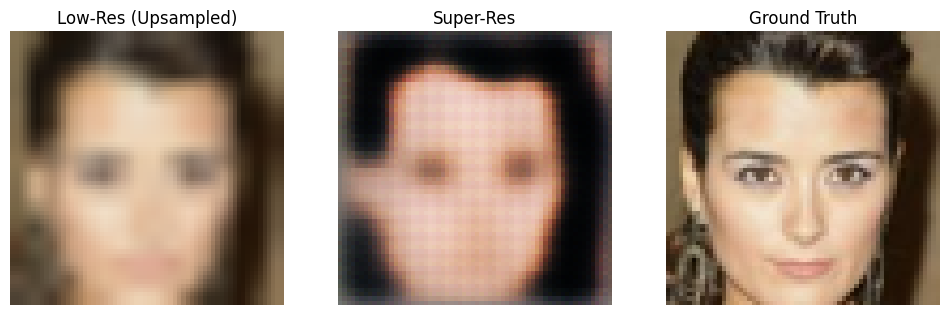

In [12]:
def visualize(lr, sr, hr):
    plt.figure(figsize=(12, 4))
    imgs = [tf.image.resize(lr, [64, 64]), sr, hr]
    titles = ['Low-Res (Upsampled)', 'Super-Res', 'Ground Truth']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(((imgs[i]+1)/2).numpy().astype(np.float32))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Run inference
for lr_imgs, hr_imgs in dataset.take(1):
    sr_imgs = generator(lr_imgs, training=False)
    visualize(lr_imgs[0], sr_imgs[0], hr_imgs[0])
